# A Diffusion Model from Scratch in Pytorch

In this notebook I want to build a very simple (as few code as possible) Diffusion Model for generating car images. I will explain all the theoretical details in the YouTube video.


**Sources:**
- Github implementation [Denoising Diffusion Pytorch](https://github.com/lucidrains/denoising-diffusion-pytorch)
- Niels Rogge, Kashif Rasul, [Huggingface notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=3a159023)
- Papers on Diffusion models ([Dhariwal, Nichol, 2021], [Ho et al., 2020] ect.)


## Investigating the dataset

As dataset we use the StandordCars Dataset, which consists of around 8000 images in the train set. Let's see if this is enough to get good results ;-)

In [42]:
import torch
import torchvision
import matplotlib.pyplot as plt
import os
from PIL import Image
from torchvision import datasets, transforms
transform=transforms.Compose([transforms.ToTensor()])
def show_images(image_folder, num_samples=4, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15, 15))
    images = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]

    for i, img_name in enumerate(images):
        if i == num_samples:
            break
        img_path = os.path.join(image_folder, img_name)
        img = Image.open(img_path)
        img_tensor = transform(img)
        print(img_tensor)

        plt.subplot(int(num_samples / cols) + 1, cols, i + 1)
        plt.imshow(img_tensor.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C) for plt.imshow

    plt.show()

tensor([[[0.1882, 0.1804, 0.1765,  ..., 0.2000, 0.2000, 0.2000],
         [0.1843, 0.1765, 0.1765,  ..., 0.1961, 0.1922, 0.1922],
         [0.1882, 0.1804, 0.1765,  ..., 0.2000, 0.2000, 0.2000],
         ...,
         [0.2078, 0.2078, 0.2078,  ..., 0.2157, 0.2118, 0.2118],
         [0.2196, 0.2196, 0.2196,  ..., 0.2235, 0.2235, 0.2235],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])
tensor([[[0.1216, 0.1137, 0.1255,  ..., 0.1294, 0.1294, 0.1255],
         [0.1333, 0.1176, 0.1255,  ..., 0.1451, 0.1412, 0.1412],
         [0.1333, 0.1137, 0.1216,  ..., 0.1412, 0.1412, 0.1373],
         ...,
         [0.1412, 0.1412, 0.1412,  ..., 0.1490, 0.1490, 0.1529],
         [0.1333, 0.1333, 0.1333,  ..., 0.1569, 0.1569, 0.1569],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])
tensor([[[0.1922, 0.1765, 0.1725,  ..., 0.2000, 0.1922, 0.1961],
         [0.1922, 0.1804, 0.1765,  ..., 0.2118, 0.2118, 0.2157],
         [0.1882, 0.1804, 0.1804,  ..., 0.2157, 0.2196, 0.

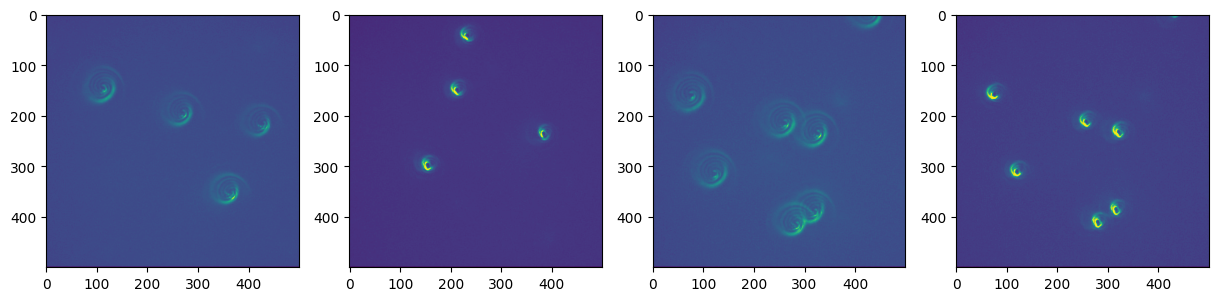

In [16]:
show_images('/content/sample_data/data')

Later in this notebook we will do some additional modifications to this dataset, for example make the images smaller, convert them to tensors ect.

# Building the Diffusion Model


## Step 1: The forward process = Noise scheduler




We first need to build the inputs for our model, which are more and more noisy images. Instead of doing this sequentially, we can use the closed form provided in the papers to calculate the image for any of the timesteps individually.

**Key Takeaways**:
- The noise-levels/variances can be pre-computed
- There are different types of variance schedules
- We can sample each timestep image independently (Sums of Gaussians is also Gaussian)
- No model is needed in this forward step

In [43]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

Number of images in dataset: 159
DataLoader is configured with batch_size=2 and shuffle=True.
Batch 0:
Images shape: torch.Size([2, 3, 64, 64])


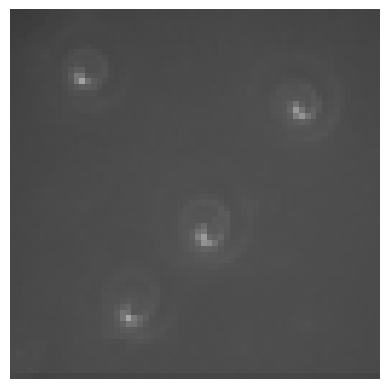

In [44]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np

IMG_SIZE = 64
BATCH_SIZE = 2
DATA_DIR = '/content/sample_data/data' # Update this to your image folder path

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_paths = [os.path.join(img_dir, img_name) for img_name in os.listdir(img_dir) if img_name.endswith('.jpg')]

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, 0  # Returning a dummy label

def load_transformed_dataset(data_dir):
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),  # Scales data into [0, 1]
        transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
    ]
    data_transform = transforms.Compose(data_transforms)

    dataset = CustomImageDataset(img_dir=data_dir, transform=data_transform)

    # Check number of images in the dataset
    print(f"Number of images in dataset: {len(dataset)}")

    return dataset

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),  # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))
    plt.axis('off')  # Hide axis for better visualization
    plt.show()

# Load the dataset
dataset = load_transformed_dataset(DATA_DIR)

if len(dataset) == 0:
    print("The dataset is empty. Please check the data directory and ensure it contains JPG images.")
else:
    # Load DataLoader
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)  # drop_last set to False

    # Check DataLoader configuration
    print(f"DataLoader is configured with batch_size={BATCH_SIZE} and shuffle=True.")

    # Try fetching and printing a batch from DataLoader
    try:
        for batch_idx, (images, _) in enumerate(dataloader):
            print(f"Batch {batch_idx}:")
            print(f"Images shape: {images.shape}")
            # Show the first image in the batch
            show_tensor_image(images[0])
            if batch_idx == 0:  # Stop after the first batch
                break
    except StopIteration:
        print("DataLoader is empty.")


Let's test it on our dataset ...

<ipython-input-45-f4853fe96c6f>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


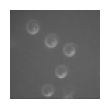

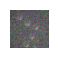

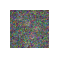

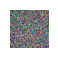

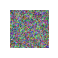

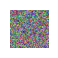

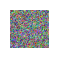

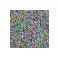

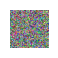

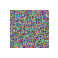

In [45]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

## Step 2: The backward process = U-Net



For a great introduction to UNets, have a look at this post: https://amaarora.github.io/2020/09/13/unet.html.


**Key Takeaways**:
- We use a simple form of a UNet for to predict the noise in the image
- The input is a noisy image, the ouput the noise in the image
- Because the parameters are shared accross time, we need to tell the network in which timestep we are
- The Timestep is encoded by the transformer Sinusoidal Embedding
- We output one single value (mean), because the variance is fixed


In [46]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor


**Further improvements that can be implemented:**
- Residual connections
- Different activation functions like SiLU, GWLU, ...
- BatchNormalization
- GroupNormalization
- Attention
- ...

## Step 3: The loss



**Key Takeaways:**
- After some maths we end up with a very simple loss function
- There are other possible choices like L2 loss ect.


In [47]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

## Sampling
- Without adding @torch.no_grad() we quickly run out of memory, because pytorch tacks all the previous images for gradient calculation
- Because we pre-calculated the noise variances for the forward pass, we also have to use them when we sequentially perform the backward process

In [48]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()

## Training

Epoch 0 | step 000 Loss: 0.8077516555786133 


<ipython-input-48-5fbd7b74e2b8>:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


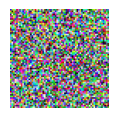

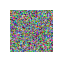

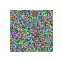

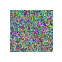

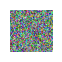

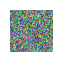

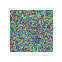

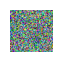

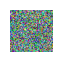

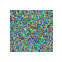

<ipython-input-47-b58b039d86e6>:4: UserWarning: Using a target size (torch.Size([2, 3, 64, 64])) that is different to the input size (torch.Size([1, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(noise, noise_pred)


Epoch 5 | step 000 Loss: 0.13325685262680054 


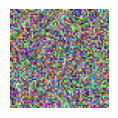

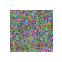

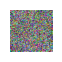

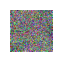

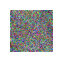

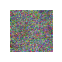

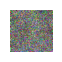

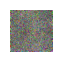

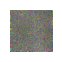

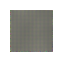

Epoch 10 | step 000 Loss: 0.3340640068054199 


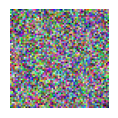

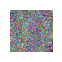

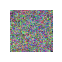

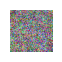

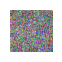

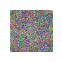

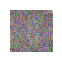

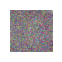

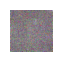

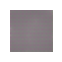

Epoch 15 | step 000 Loss: 0.09587403386831284 


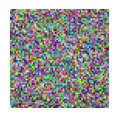

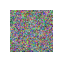

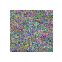

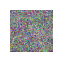

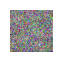

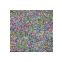

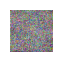

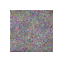

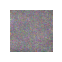

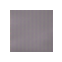

Epoch 20 | step 000 Loss: 0.08563263714313507 


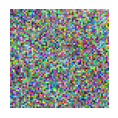

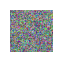

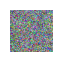

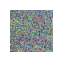

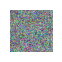

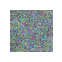

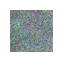

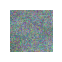

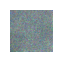

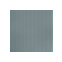

Epoch 25 | step 000 Loss: 0.12898407876491547 


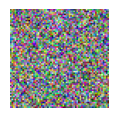

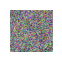

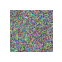

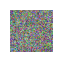

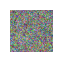

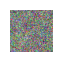

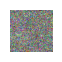

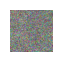

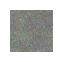

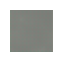

Epoch 30 | step 000 Loss: 0.06932683289051056 


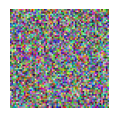

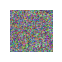

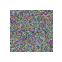

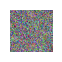

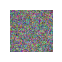

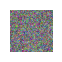

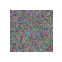

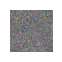

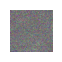

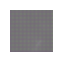

Epoch 35 | step 000 Loss: 0.09472738206386566 


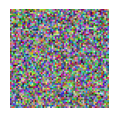

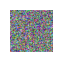

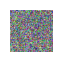

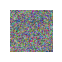

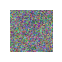

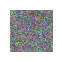

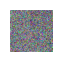

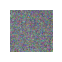

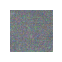

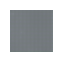

Epoch 40 | step 000 Loss: 0.09033878147602081 


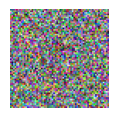

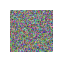

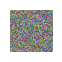

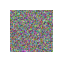

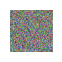

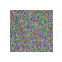

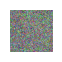

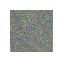

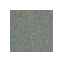

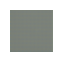

Epoch 45 | step 000 Loss: 0.06204747408628464 


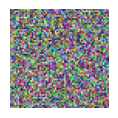

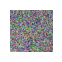

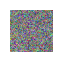

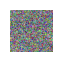

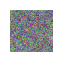

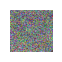

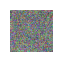

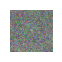

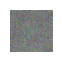

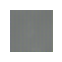

Epoch 50 | step 000 Loss: 0.06436540931463242 


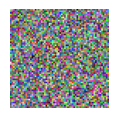

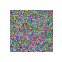

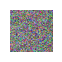

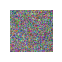

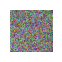

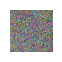

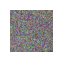

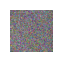

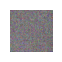

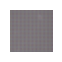

Epoch 55 | step 000 Loss: 0.09225239604711533 


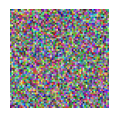

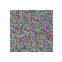

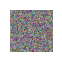

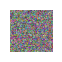

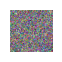

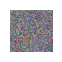

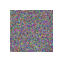

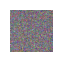

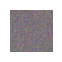

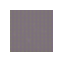

Epoch 60 | step 000 Loss: 0.06380392611026764 


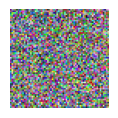

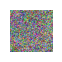

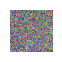

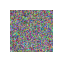

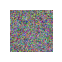

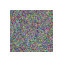

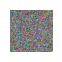

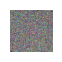

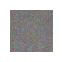

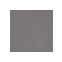

Epoch 65 | step 000 Loss: 0.0741049125790596 


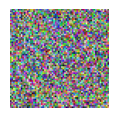

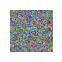

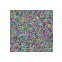

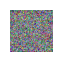

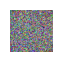

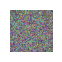

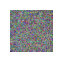

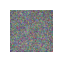

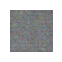

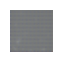

Epoch 70 | step 000 Loss: 0.056697674095630646 


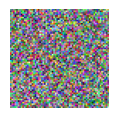

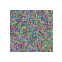

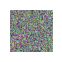

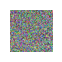

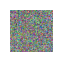

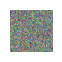

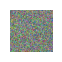

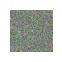

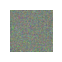

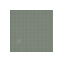

Epoch 75 | step 000 Loss: 0.06312678754329681 


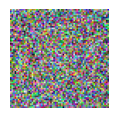

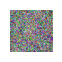

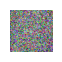

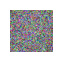

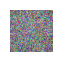

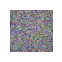

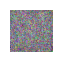

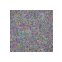

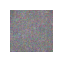

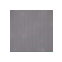

Epoch 80 | step 000 Loss: 0.07066063582897186 


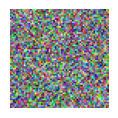

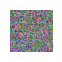

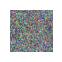

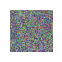

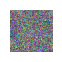

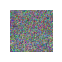

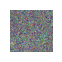

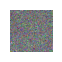

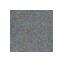

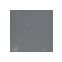

Epoch 85 | step 000 Loss: 0.08077479153871536 


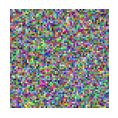

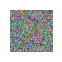

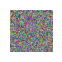

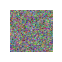

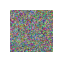

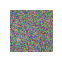

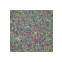

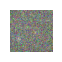

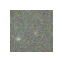

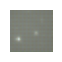

Epoch 90 | step 000 Loss: 0.06342237442731857 


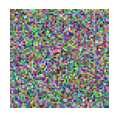

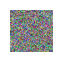

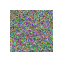

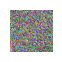

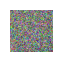

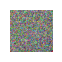

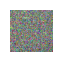

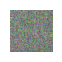

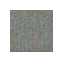

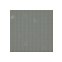

Epoch 95 | step 000 Loss: 0.051237206906080246 


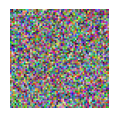

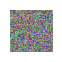

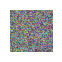

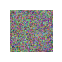

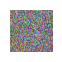

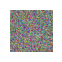

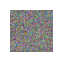

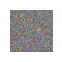

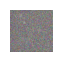

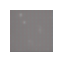

Epoch 100 | step 000 Loss: 0.08721329271793365 


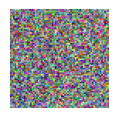

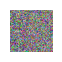

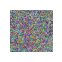

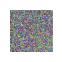

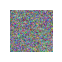

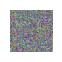

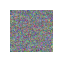

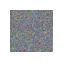

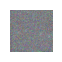

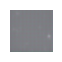

Epoch 105 | step 000 Loss: 0.05218231678009033 


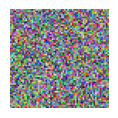

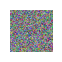

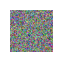

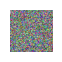

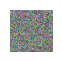

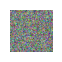

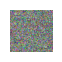

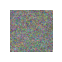

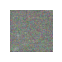

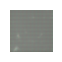

Epoch 110 | step 000 Loss: 0.06651388108730316 


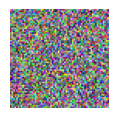

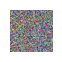

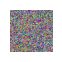

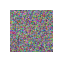

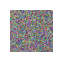

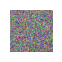

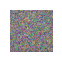

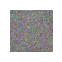

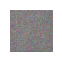

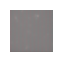

Epoch 115 | step 000 Loss: 0.0540994331240654 


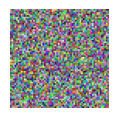

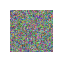

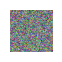

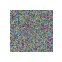

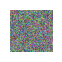

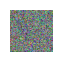

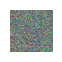

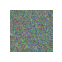

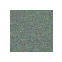

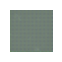

Epoch 120 | step 000 Loss: 0.04530280828475952 


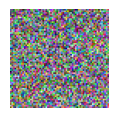

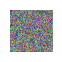

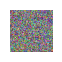

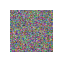

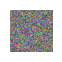

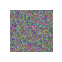

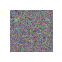

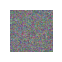

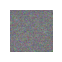

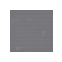

Epoch 125 | step 000 Loss: 0.05104359984397888 


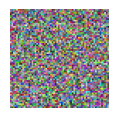

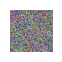

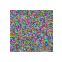

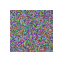

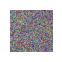

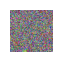

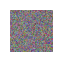

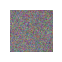

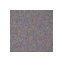

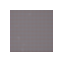

Epoch 130 | step 000 Loss: 0.04789445921778679 


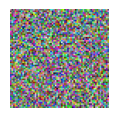

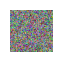

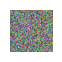

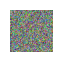

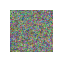

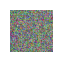

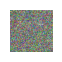

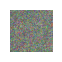

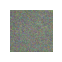

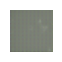

Epoch 135 | step 000 Loss: 0.1284724771976471 


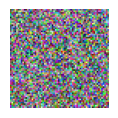

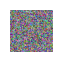

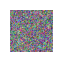

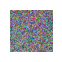

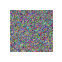

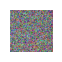

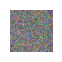

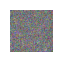

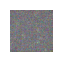

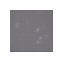

Epoch 140 | step 000 Loss: 0.06607570499181747 


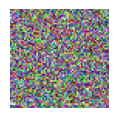

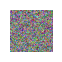

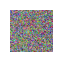

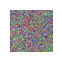

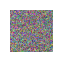

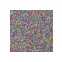

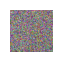

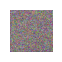

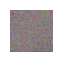

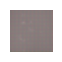

Epoch 145 | step 000 Loss: 0.05041540786623955 


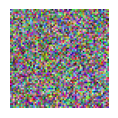

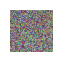

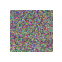

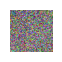

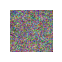

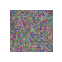

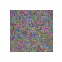

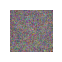

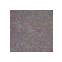

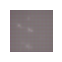

Epoch 150 | step 000 Loss: 0.06157355755567551 


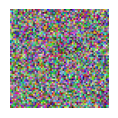

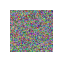

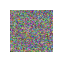

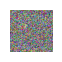

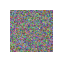

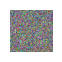

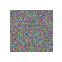

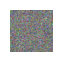

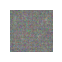

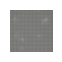

Epoch 155 | step 000 Loss: 0.043278198689222336 


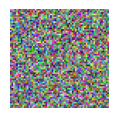

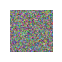

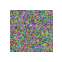

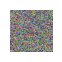

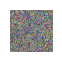

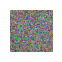

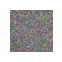

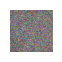

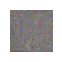

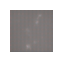

Epoch 160 | step 000 Loss: 0.04905613511800766 


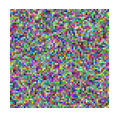

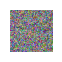

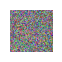

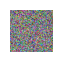

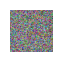

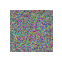

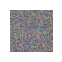

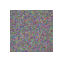

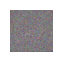

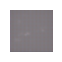

Epoch 165 | step 000 Loss: 0.04871457815170288 


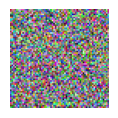

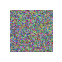

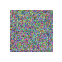

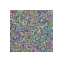

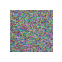

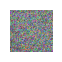

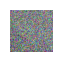

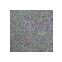

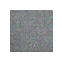

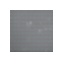

Epoch 170 | step 000 Loss: 0.041479311883449554 


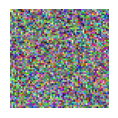

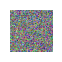

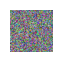

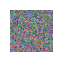

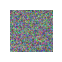

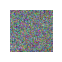

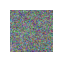

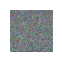

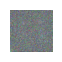

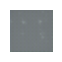

Epoch 175 | step 000 Loss: 0.04728779196739197 


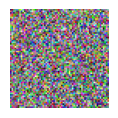

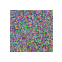

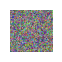

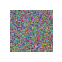

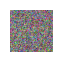

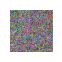

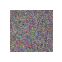

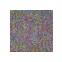

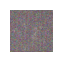

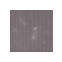

Epoch 180 | step 000 Loss: 0.14430087804794312 


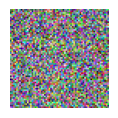

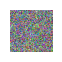

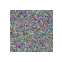

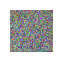

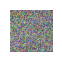

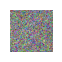

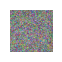

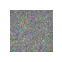

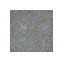

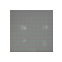

Epoch 185 | step 000 Loss: 0.06805083155632019 


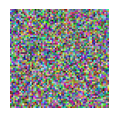

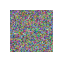

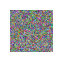

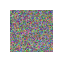

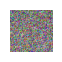

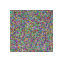

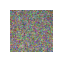

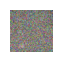

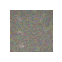

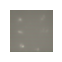

Epoch 190 | step 000 Loss: 0.03696043789386749 


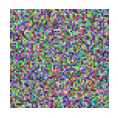

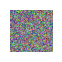

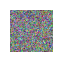

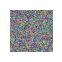

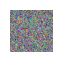

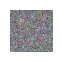

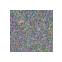

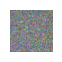

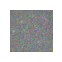

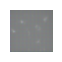

Epoch 195 | step 000 Loss: 0.05040430277585983 


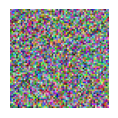

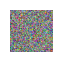

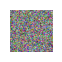

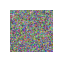

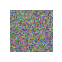

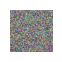

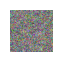

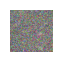

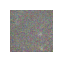

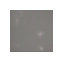

Epoch 200 | step 000 Loss: 0.044787049293518066 


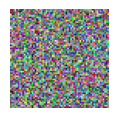

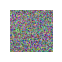

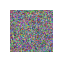

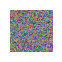

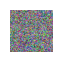

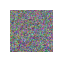

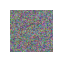

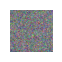

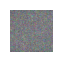

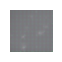

Epoch 205 | step 000 Loss: 0.039528317749500275 


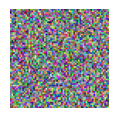

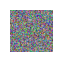

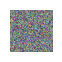

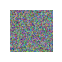

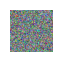

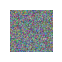

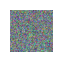

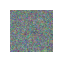

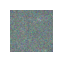

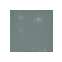

Epoch 210 | step 000 Loss: 0.04111884906888008 


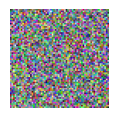

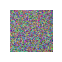

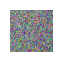

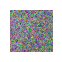

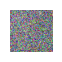

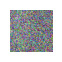

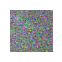

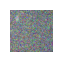

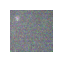

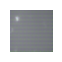

Epoch 215 | step 000 Loss: 0.04152930527925491 


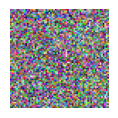

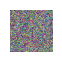

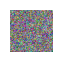

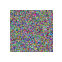

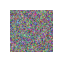

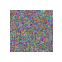

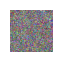

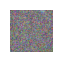

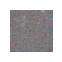

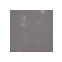

Epoch 220 | step 000 Loss: 0.07025960087776184 


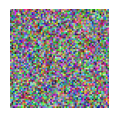

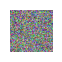

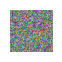

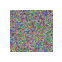

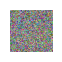

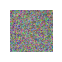

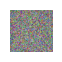

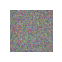

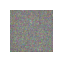

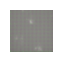

Epoch 225 | step 000 Loss: 0.049371249973773956 


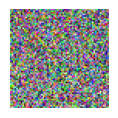

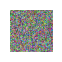

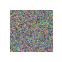

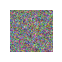

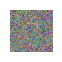

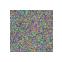

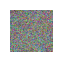

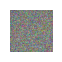

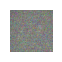

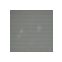

Epoch 230 | step 000 Loss: 0.04245883971452713 


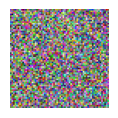

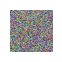

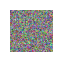

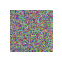

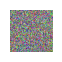

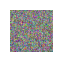

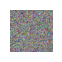

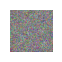

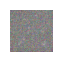

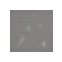

Epoch 235 | step 000 Loss: 0.06153059005737305 


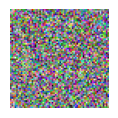

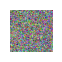

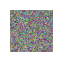

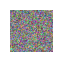

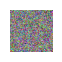

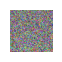

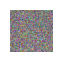

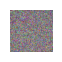

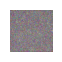

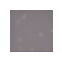

Epoch 240 | step 000 Loss: 0.0748174786567688 


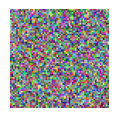

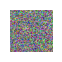

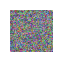

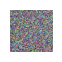

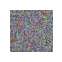

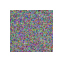

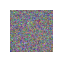

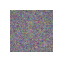

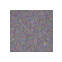

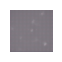

Epoch 245 | step 000 Loss: 0.06387791037559509 


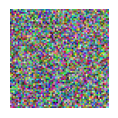

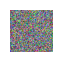

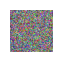

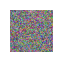

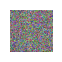

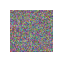

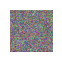

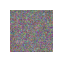

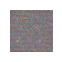

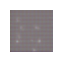

Epoch 250 | step 000 Loss: 0.05352842062711716 


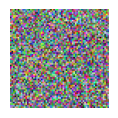

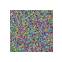

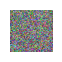

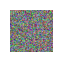

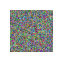

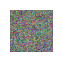

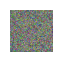

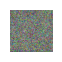

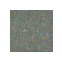

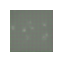

Epoch 255 | step 000 Loss: 0.05137815326452255 


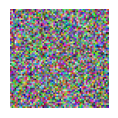

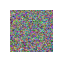

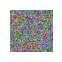

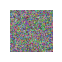

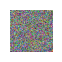

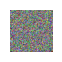

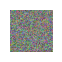

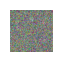

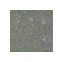

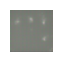

Epoch 260 | step 000 Loss: 0.04146682098507881 


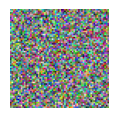

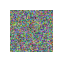

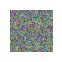

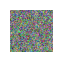

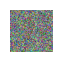

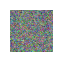

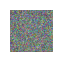

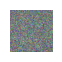

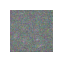

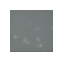

Epoch 265 | step 000 Loss: 0.06621235609054565 


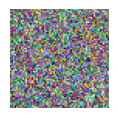

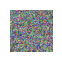

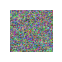

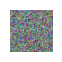

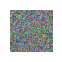

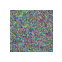

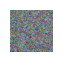

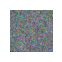

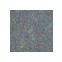

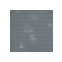

Epoch 270 | step 000 Loss: 0.0559074692428112 


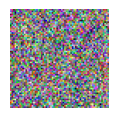

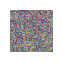

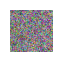

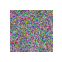

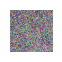

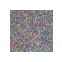

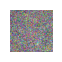

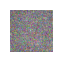

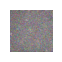

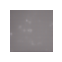

Epoch 275 | step 000 Loss: 0.038321904838085175 


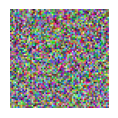

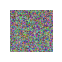

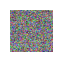

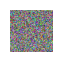

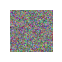

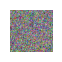

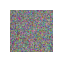

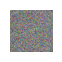

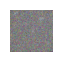

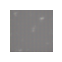

Epoch 280 | step 000 Loss: 0.06393439322710037 


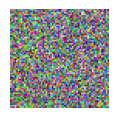

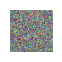

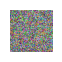

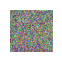

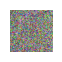

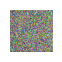

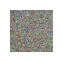

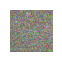

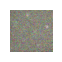

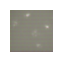

Epoch 285 | step 000 Loss: 0.03952309489250183 


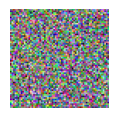

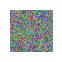

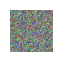

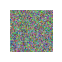

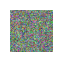

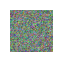

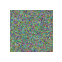

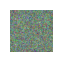

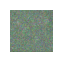

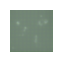

Epoch 290 | step 000 Loss: 0.05346965789794922 


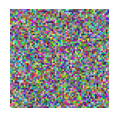

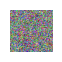

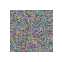

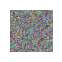

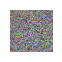

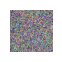

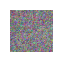

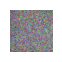

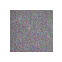

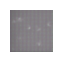

Epoch 295 | step 000 Loss: 0.045675840228796005 


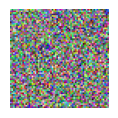

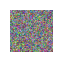

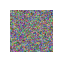

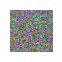

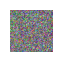

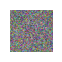

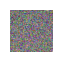

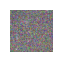

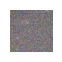

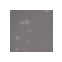

Epoch 300 | step 000 Loss: 0.06678923219442368 


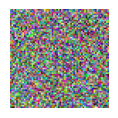

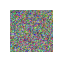

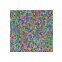

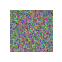

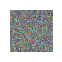

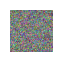

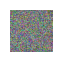

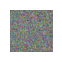

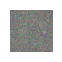

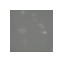

Epoch 305 | step 000 Loss: 0.06759504973888397 


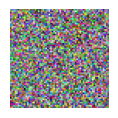

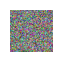

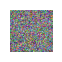

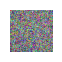

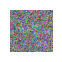

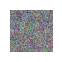

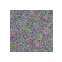

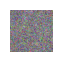

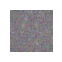

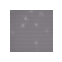

Epoch 310 | step 000 Loss: 0.13289636373519897 


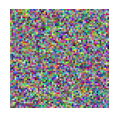

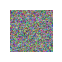

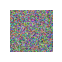

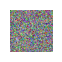

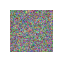

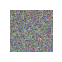

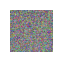

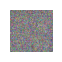

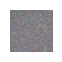

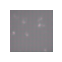

Epoch 315 | step 000 Loss: 0.035327062010765076 


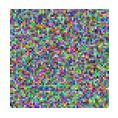

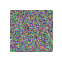

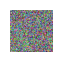

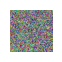

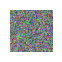

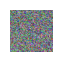

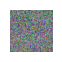

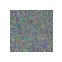

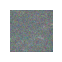

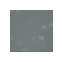

Epoch 320 | step 000 Loss: 0.09708647429943085 


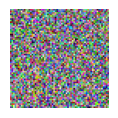

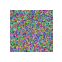

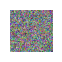

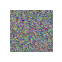

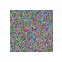

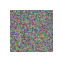

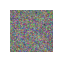

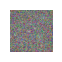

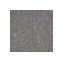

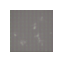

Epoch 325 | step 000 Loss: 0.19640004634857178 


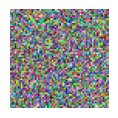

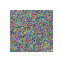

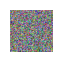

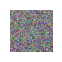

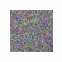

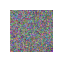

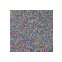

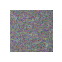

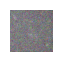

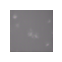

Epoch 330 | step 000 Loss: 0.04826884716749191 


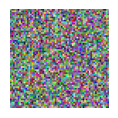

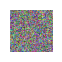

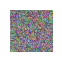

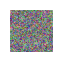

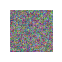

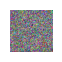

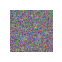

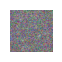

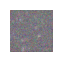

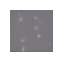

Epoch 335 | step 000 Loss: 0.04083329066634178 


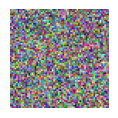

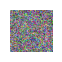

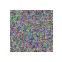

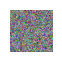

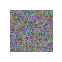

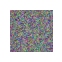

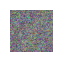

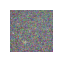

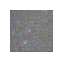

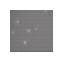

Epoch 340 | step 000 Loss: 0.051871538162231445 


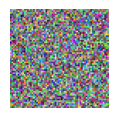

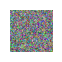

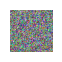

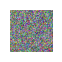

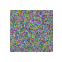

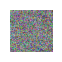

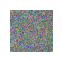

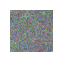

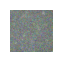

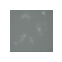

Epoch 345 | step 000 Loss: 0.03752737119793892 


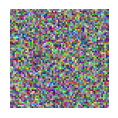

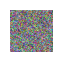

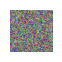

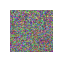

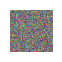

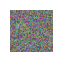

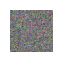

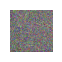

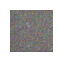

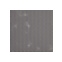

Epoch 350 | step 000 Loss: 0.1220756322145462 


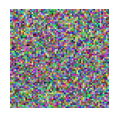

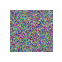

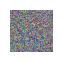

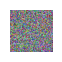

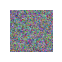

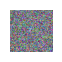

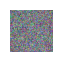

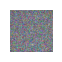

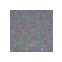

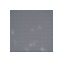

Epoch 355 | step 000 Loss: 0.04023917019367218 


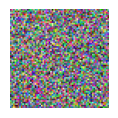

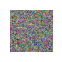

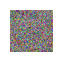

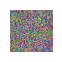

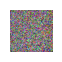

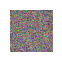

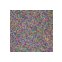

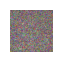

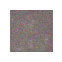

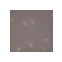

Epoch 360 | step 000 Loss: 0.03308963030576706 


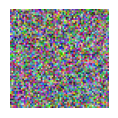

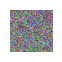

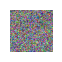

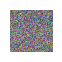

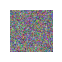

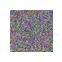

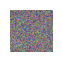

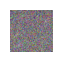

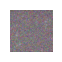

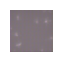

Epoch 365 | step 000 Loss: 0.06427093595266342 


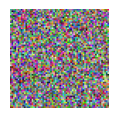

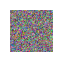

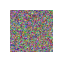

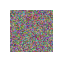

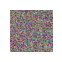

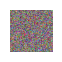

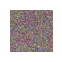

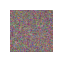

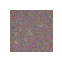

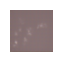

Epoch 370 | step 000 Loss: 0.054670076817274094 


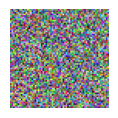

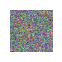

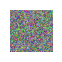

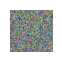

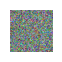

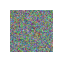

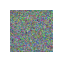

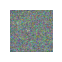

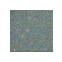

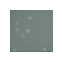

Epoch 375 | step 000 Loss: 0.12789073586463928 


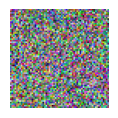

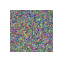

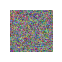

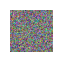

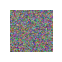

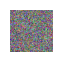

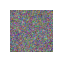

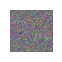

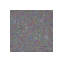

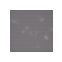

Epoch 380 | step 000 Loss: 0.09012572467327118 


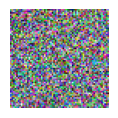

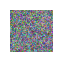

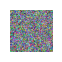

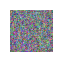

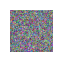

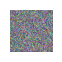

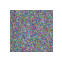

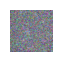

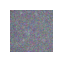

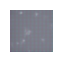

Epoch 385 | step 000 Loss: 0.05396192520856857 


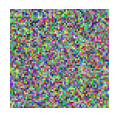

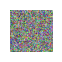

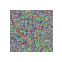

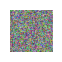

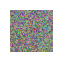

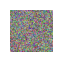

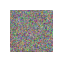

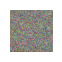

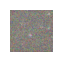

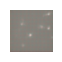

Epoch 390 | step 000 Loss: 0.04288623854517937 


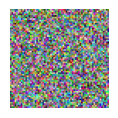

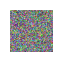

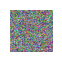

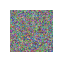

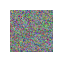

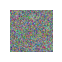

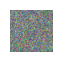

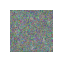

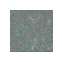

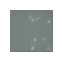

Epoch 395 | step 000 Loss: 0.15173982083797455 


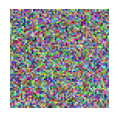

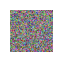

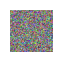

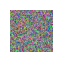

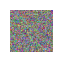

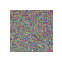

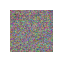

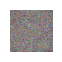

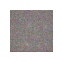

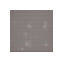

In [ ]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 10000 # Try more!

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch[0], t)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()